In [1]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_UDfit, udfit_values

In [2]:
def check_multidatasets(fitsfile, verbose = False):
    count = 0
    for i, hdu in enumerate(fitsfile):
        name = 'OI_VIS2'
        if hdu.name == name:
            if hdu.ver:
                count +=1
    if verbose:
        print("Nights:", count)
    return count

def unpack_multidatasets(fitsfile, count, verbose = False):
    if count > 1:
        v2_list = []
        dv2_list = []
        uc_list = []
        vc_list = []
        mjd_list = []
        time_list = []
        wl_list = []
        band_list = []
        if verbose:
            print("Multiple nights")
        for i in range(count):
            if verbose:
                print("Version:", i + 1)
            v2 = fitsfile["OI_VIS2", i + 1].data["VIS2DATA"]
            dv2 = fitsfile["OI_VIS2", i + 1].data["VIS2ERR"]
            ucoord = fitsfile["OI_VIS2", i + 1].data["UCOORD"]
            vcoord = fitsfile["OI_VIS2", i + 1].data["VCOORD"]
            mjd = fitsfile["OI_VIS2", i + 1].data["MJD"]
            time = fitsfile["OI_VIS2", i + 1].data["TIME"]
            wl = fitsfile["OI_WAVELENGTH", i + 1].data["EFF_WAVE"]
            band = fitsfile["OI_WAVELENGTH", i + 1].data["EFF_BAND"]

            wll = [wl.tolist() for _ in range(len(v2))]
            bandl = [band.tolist() for _ in range(len(v2))]

            v2_list.append(v2)
            dv2_list.append(dv2)
            uc_list.append(ucoord)
            vc_list.append(vcoord)
            mjd_list.append(mjd)
            time_list.append(time)
            wl_list.append(wll)
            band_list.append(bandl)
        pd.set_option('display.float_format', '{:.12f}'.format)
        df = pd.DataFrame({'MJD': mjd_list, 'Time': time_list, 'V2': v2_list, 'V2_err': dv2_list,
                           'Eff_wave[m]': wl_list, 'Eff_band[m]': band_list, 'UCOORD[m]': uc_list,
                           'VCOORD[m]': vc_list})
        df_e = df.apply(pd.Series.explode)
        return df_e
    else:
        if verbose:
            print("Only one night.")
        v2 = fitsfile["OI_VIS2"].data["VIS2DATA"]
        dv2 = fitsfile["OI_VIS2"].data["VIS2ERR"]
        ucoord = fitsfile["OI_VIS2"].data["UCOORD"]
        vcoord = fitsfile["OI_VIS2"].data["VCOORD"]
        mjd = fitsfile["OI_VIS2"].data["MJD"]
        time = fitsfile["OI_VIS2"].data["TIME"]
        wl = fitsfile["OI_WAVELENGTH"].data["EFF_WAVE"]
        band = fitsfile["OI_WAVELENGTH"].data["EFF_BAND"]

        wl_list = [wl.tolist() for _ in range(len(v2))]
        band_list = [band.tolist() for _ in range(len(v2))]

        pd.set_option('display.float_format', '{:.12f}'.format)
        df = pd.DataFrame({'MJD': mjd, 'Time': time, 'V2': v2.tolist(), 'V2_err': dv2.tolist(),
                           'Eff_wave[m]': wl_list, 'Eff_band[m]': band_list, 'UCOORD[m]': ucoord, 'VCOORD[m]': vcoord})

        return df


def oifits_to_pandas(filename, inst_name):
    # Reads in an oifits file and converts into a pandas dataframe with the necessary information needed for RADPy
    # Extracts the following data:
    #   V2, dv2, ucoord, vcoord, mjd, time, effective wavelength, and effective bandwidth
    # Converts the wavelengths and bandwidth arrays into lists of lists to match the V2 and V2err lists
    # creates a dataframe
    # Sorts the dataframe by MJD and then assigns a bracket number based on the date groupings
    # Explodes the dataframe by extracting out each list for V2, V2_err, wavelength, and bandwidth
    # returns the exploded, sorted, and bracket labeled df

    data = fits.open(filename)
    count = check_multidatasets(data)
    new_df = unpack_multidatasets(data,count)
    sorted_df = brackets(new_df, inst_name)
    sorted_df['zipped'] = sorted_df.apply(
        lambda row: list(zip(row['V2'], row['V2_err'], row['Eff_wave[m]'], row['Eff_band[m]'])), axis=1)
    df_exploded = sorted_df.explode('zipped').reset_index(drop=True)
    df_exploded[['V2', 'V2_err', 'Eff_wave[m]', 'Eff_band[m]']] = pd.DataFrame(df_exploded['zipped'].tolist(),
                                                                               index=df_exploded.index)
    df_exploded = df_exploded.drop(columns='zipped')
    df_exploded['Instrument'] = [inst_name] * len(df_exploded)

    return df_exploded

In [3]:
filenamec = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\ClassicData.csv"
filenamep = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\PAVOdata.csv"
filenamev = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\Vegadata.csv"
filenamem = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MIRCX_June11162025_HD_219134.oifits"
filenamemy = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MYSTIC_June11162025_HD_219134.oifits"

In [4]:
datav, num_brack_v = filename_extension(filenamev, 'V')
datac, num_brack_c = filename_extension(filenamec, 'C')
datap, num_brack_p = filename_extension(filenamep, 'P')
datam, num_brack_m = filename_extension(filenamem, 'M')
datamy, num_brack_my = filename_extension(filenamemy, 'My')

Number of brackets: 20
Number of brackets: 1
Number of brackets: 17
Number of brackets: 18
Number of brackets: 30


In [5]:
pavo_data = PavoData(datap)
vega_data = VegaData(datav)
classic_data = ClassicData(datac)
mircx_data = MircxData(datam)
mystic_data = MysticData(datamy)

In [6]:
df_m = mircx_data.make_df()
df_my = mystic_data.make_df()
df_p = pavo_data.make_df()
df_v = vega_data.make_df()
df_c = classic_data.make_df()

In [7]:
b, v2, dv2, wave, band, brack, inst = combined(df_p, df_c, df_v)
spf = b/wave

In [8]:
star = StellarParams()
p = 152.864
dp = 0.0494
f = 21.751
df = 0.585
logg = 4.5
dlogg = 0.1
m = 0.09
dm = 0.08

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm
star.plx = p
star.plx_err = dp

In [9]:
D, dD = distances('HD 219134', verbose = True)
star.dist = D
star.dist_err = dD

Found Gaia DR3 ID: Gaia DR3 2009481748875806976
Corrected parallax: 152.83842 [mas]
Distance: 6.54286 +/- 0.00212 [pc]


C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


In [10]:
theta1, dtheta1, chisqr1 = initial_UDfit(spf, v2, dv2, 0.4, star, verbose = True)


Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 461
    # variables        = 1
    chi-square         = 583.593270
    reduced chi-square = 1.26868102
    Akaike info crit   = 110.706678
    Bayesian info crit = 114.840076
    R-squared          = -60.2680353
[[Variables]]
    theta:  1.03756289 +/- 0.00128204 (0.12%) (init = 0.4)


In [11]:
theta2, dtheta2, chisqr2 = initial_LDfit(spf, v2, dv2, star, 'R', verbose = True)

Effective temperature: 4963.23239 +/- 33.51206 K
LDC for filter  R : 0.6672
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 461
    # variables        = 1
    chi-square         = 578.043019
    reduced chi-square = 1.25661526
    Akaike info crit   = 106.301366
    Bayesian info crit = 110.434764
    R-squared          = -59.6853470
[[Variables]]
    theta:  1.11365607 +/- 0.00140433 (0.13%) (init = 1.03756)


In [12]:
theta_results = run_UDfit(5, 5, datasets = [pavo_data, vega_data, classic_data], 
                                      stellar_params = star)

In [13]:
udfit_values(spf, v2, dv2, theta_results, stellar_params = star, verbose = True)

Uniform Disk Diameter after MC/BS: 1.0372 +/- 0.00456 mas
Chi-squared: 20.905
Chi-squared reduced: 0.045
Temperature: 4964.2 +/- 35.1 K


In [14]:
thetaf, dthetaf, tf, dtf, ldcsf, chisf = run_LDfit(2, 2, ogdata = [spf, v2, dv2], 
                                                                 datasets = [pavo_data, vega_data, classic_data], 
                                                                 stellar_params = star, verbose = True)

Final Values after  16  iterations:
Limb-darkened Disk Diameter after MC/BS: 1.1098 +/- 0.00696 mas
Limb-darkening coefficient in R: 0.68348
Chi-squared for R band: 599.484
Reduced chi-squared for R band: 1.303
Limb-darkening coefficient in K: 0.32177
Chi-squared for K band: 1410.744
Reduced chi-squared for K band: 3.067
Temperature: 4798.9 +/- 35.6 K
Percent difference: 0.02 %
Percent difference: 0.04 %


In [15]:
calc_star_params(star, verbose = True)

Linear Radius:  0.782 +/- 0.005 [R_solar]
Luminosity:  0.291 +/- 0.008 [L_solar]
Effective temperature:  4798.958 +/- 35.604 [K]


In [16]:
data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}
#data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data, 'mircx':mircx_data,'mystic':mystic_data}

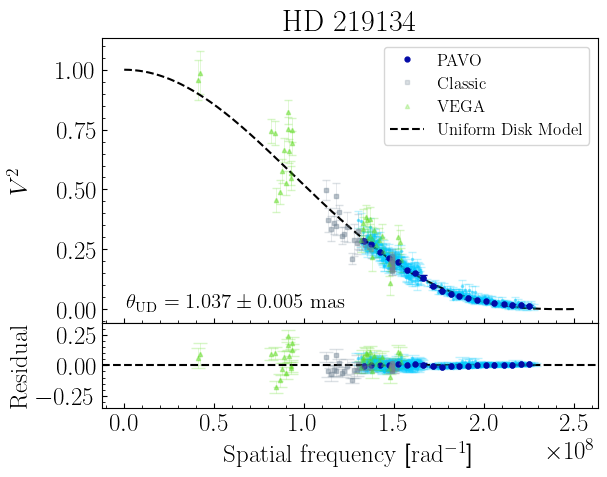

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [17]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['pavo', 'classic', 'vega'],
    to_bin = ['pavo'],
    plot_udmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

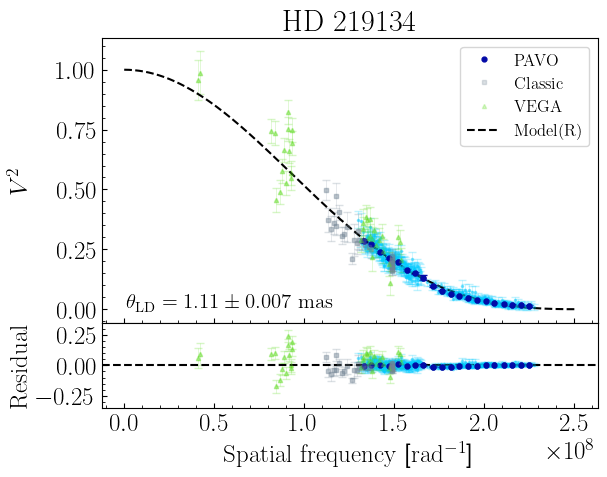

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [18]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['pavo', 'classic', 'vega'],
    to_bin = [ 'pavo'],
    ldc_band = 'ldc_R',
    plot_ldmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )